# Downloading repositories and data

In [ ]:
!git clone https://github.com/mskv99/Defect-Detection.git

In [ ]:
%cd /content/Defect-Detection/NetDirectory/
!pwd

In [ ]:
#first version of dataset
#!curl -L "https://app.roboflow.com/ds/UKv4tybmhd?key=cS4UxrytMH" > roboflow.zip; unzip roboflow.zip -d custom_data; rm roboflow.zip

#second version of dataset

!curl -L "https://app.roboflow.com/ds/EKzbJNgSDg?key=xJdZLnl59h" > roboflow.zip; unzip roboflow.zip -d custom_data; rm roboflow.zip

In [ ]:
!pip install wandb


In [ ]:
!pip install torchmetrics


In [6]:
!pip install torchinfo

In [7]:
!wandb login

#api key for weights and biases: 7f7117ef2660f827c823ba03863048fe0eea4801

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
import wandb

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="FasterRCNN",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.009474,
    "architecture": "ResNet101",
    "dataset": "Defect_dataset_v2",
    "epochs": 50,
    "optimizer" : "SGD",
    "batch_size" : "3",
    "augmentations" : 'blur',
    "scheduler" : 'step_lr_10_ep_gamma_0.1'
    }
)



wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


In [9]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import os
import glob as glob
from google.colab.patches import cv2_imshow

from xml.etree import ElementTree as et
import random
from torch.utils.data import Dataset, DataLoader

from custom_utils import (
    Averager,
    SaveBestModel,
    save_model,
    save_loss_plot,
    save_mAP
)
from tqdm.auto import tqdm

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import time
import os


def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(42)

# Creating dataset class and applying transforms


In [10]:
BATCH_SIZE = 3 # Increase / decrease according to GPU memeory.
RESIZE_TO = 640 # Resize the image for training and transforms.
NUM_EPOCHS = 50 # Number of epochs to train for.
NUM_WORKERS = 2 # Number of parallel workers for data loading.
LEARNING_RATE = 0.009474
STEP = 10
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Training images and XML files directory.
TRAIN_DIR = '/content/Defect-Detection/NetDirectory/custom_data/train'
# Validation images and XML files directory.
VALID_DIR = '/content/Defect-Detection/NetDirectory/custom_data/valid'

CLASSES = [
    '__background__', 'bridge', 'collapse', 'gap', 'sraf'
]

NUM_CLASSES = len(CLASSES)

# Whether to visualize images after crearing the data loaders.
VISUALIZE_TRANSFORMED_IMAGES = False

# Location to save model and plots.
OUT_DIR = '/content/Defect-Detection/NetDirectory/outputs'



In [11]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# Define the training tranforms.
def get_train_transform():
    return A.Compose([
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.MotionBlur(blur_limit=3, p=0.5),
            A.MedianBlur(blur_limit=3, p=0.5),
        ], p=0.5),
        A.ToGray(p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# Define the validation transforms.
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def log_bounding_boxes(image, v_boxes, v_labels, v_scores):
  all_boxes = []
  for b_i, box in enumerate(v_boxes):
    # get coordiantes and labels
    box_data = {"position" : {
              "minX" : box.xmin,
              "maxX" : box.xmax,
              "minY" : box.ymin,
              "maxY" : box.ymax},
              "class_id" : display_ids[v_labels[(b_i).numpy().astype(np.int32)]],
              # optionally caption each box with its class and score
              "box_caption" : "%s (%.3f)" % (v_labels[b_i], v_scores[b_i]),
              "domain" : "pixel",
              "scores" : { "score" : v_scores[b_i] }}
    all_boxes.append(box_data)
    #log to wandb: image, predictions and dictionary of class labels for each class id
    #box_image = wandb.Image(image, boxes = {"predictions": {"box_data"} })
    box_image = wandb.Image(image, boxes = {"predictions": {"box_data": all_boxes, "class_labels" : class_id_to_label}})
    wandb.log({"bounding_boxes": box_image})


In [12]:

# The dataset class.
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        self.image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm', '*.JPG']
        self.all_image_paths = []

        # Get all the image paths in sorted order.
        for file_type in self.image_file_types:
            self.all_image_paths.extend(glob.glob(os.path.join(self.dir_path, file_type)))
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.all_image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # Capture the image name and the full image path.
        image_name = self.all_images[idx]

        image_path = os.path.join(self.dir_path, image_name)

        # Read and preprocess the image.
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        #image_resized /= 255.0

        # Capture the corresponding XML file for getting the annotations.
        annot_filename = os.path.splitext(image_name)[0] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # Original image width and height.
        image_width = image.shape[1]
        image_height = image.shape[0]

        # Box coordinates for xml files are extracted
        # and corrected for image size given.
        for member in root.findall('object'):
            # Get label and map the `classes`.
            labels.append(self.classes.index(member.find('name').text))

            # Left corner x-coordinates.
            xmin = int(member.find('bndbox').find('xmin').text)
            # Right corner x-coordinates.
            xmax = int(member.find('bndbox').find('xmax').text)
            # Left corner y-coordinates.
            ymin = int(member.find('bndbox').find('ymin').text)
            # Right corner y-coordinates.
            ymax = int(member.find('bndbox').find('ymax').text)

            # Resize the bounding boxes according
            # to resized image `width`, `height`.
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height

            # Check that all coordinates are within the image.
            if xmax_final > self.width:
                xmax_final = self.width
            if ymax_final > self.height:
                ymax_final = self.height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        # Bounding box to tensor.
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Area of the bounding boxes.
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 \
            else torch.as_tensor(boxes, dtype=torch.float32)
        # No crowd instances.
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # Labels to tensor.
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Prepare the final `target` dictionary.
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # Apply the image transforms.
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        if np.isnan((target['boxes']).numpy()).any() or target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.zeros((0, 4), dtype=torch.int64)
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# Prepare the final datasets and data loaders.
def create_train_dataset(DIR):
    train_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform()
    )
    return train_dataset
def create_valid_dataset(DIR):
    valid_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform()
    )
    return valid_dataset
def create_train_loader(train_dataset, num_workers=0, B_SIZE = BATCH_SIZE):
    train_loader = DataLoader(
        train_dataset,
        batch_size = B_SIZE,
        shuffle=True,
        num_workers = num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=0, B_SIZE = BATCH_SIZE):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size = B_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return valid_loader





# sanity check of the Dataset pipeline with sample visualization
dataset = CustomDataset(
    TRAIN_DIR, RESIZE_TO, RESIZE_TO,CLASSES, transforms = None
)
print(f"Number of training images: {len(dataset)}")



#colors = np.random.randint(0,255, size=(len(CLASSES), 3))
colors = np.random.uniform(0, 255, size=(len(CLASSES), 3))

def visualize_sample(image, target):

    pred_classes = [CLASSES[i] for i in target['labels']]
    for box_num in range(len(target['boxes'])):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        box = target['boxes'][box_num]
        #label = CLASSES[target['labels'][box_num]]
        class_name = pred_classes[box_num]
        COLOR = colors[CLASSES.index(class_name)]


        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            color = COLOR[::-1],
            thickness = 2
        )
        cv2.putText(
            image,
            class_name,
            (int(box[0]), int(box[1]-5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            color = COLOR[::-1],
            thickness = 2
        )
        #print(colors[CLASSES.index(label)])
    cv2_imshow(image)
    print('\n','\n')

Number of training images: 250


In [13]:
def show_tranformed_image(train_loader, device, classes, colors):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    """
    if len(train_loader) > 0:
        for i in range(5):
            images, targets = next(iter(train_loader))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            # Get all the predicited class names.
            pred_classes = [classes[i] for i in targets[i]['labels'].cpu().numpy()]
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)

            lw = max(round(sum(sample.shape) / 2 * 0.003), 2)  # Line width.
            tf = max(lw - 1, 1) # Font thickness.

            for box_num, box in enumerate(boxes):
                p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
                class_name = pred_classes[box_num]
                color = colors[classes.index(class_name)]
                cv2.rectangle(
                    sample,
                    p1,
                    p2,
                    color,
                    2,
                    cv2.LINE_AA
                )
                w, h = cv2.getTextSize(
                    class_name,
                    0,
                    fontScale=lw / 3,
                    thickness=tf
                )[0]  # text width, height
                outside = p1[1] - h >= 3
                p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
                cv2.putText(
                    sample,
                    class_name,
                    (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    color,
                    2,
                    cv2.LINE_AA
                )
            cv2_imshow(sample)


In [ ]:
random_numb = random.sample(range(0,len(dataset)), 5)
print(random_numb)

for _,j in enumerate(random_numb):
  image, target = dataset[j]
  visualize_sample(image, target)

In [14]:
train_dataset = create_train_dataset(TRAIN_DIR)
train_loader = create_train_loader(train_dataset, NUM_WORKERS)

valid_dataset = create_valid_dataset(VALID_DIR)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)


In [ ]:
show_tranformed_image(train_loader, DEVICE, CLASSES, colors)


# Creating a model and defining optimizer


In [ ]:
import sys

sys.path.append('/content/Defect-Detection/NetDirectory/models/faster_rcnn')

import fasterrcnn_resnet101
from fasterrcnn_resnet101 import create_model

#createting fasterrcnn_resnet101 model
model = create_model(num_classes = NUM_CLASSES, pretrained = True, coco_model = True)
model = model.to(DEVICE)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = LEARNING_RATE, momentum=0.9, nesterov=True)
#optimizer = torch.optim.Adam(params, lr=0.00001, weight_decay=0.0005)
scheduler = StepLR(
    optimizer=optimizer, step_size = STEP, gamma=0.1, verbose=True
)

# Training and validation

In [18]:

plt.style.use('ggplot')

# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    cumm_loss = 0

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        cumm_loss += loss_value
        #train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return cumm_loss / len(train_data_loader)

# Function for running validation iterations.
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()

    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images, targets)

        #losses = sum(loss for loss in outputs.values())
        #val_loss_value = losses.item()

        #val_loss_hist.send(val_loss_value)


        # For mAP calculation using Torchmetrics.
        #####################################
        for i, image in enumerate(images):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)

            # log first six images from each batch
            # if i < 6:
            #   log_bounding_boxes(image, preds_dict['boxes'], preds_dict['labels'],
            #                      preds_dict['scores'] )
        #####################################



    metric.reset()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary


In [21]:
os.makedirs('outputs', exist_ok=True)


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")


Number of training samples: 250
Number of validation samples: 68



In [ ]:
# To monitor training loss
#train_loss_hist = Averager()


# To store training loss and mAP values.
train_loss_list = []
#val_loss_list = []
map_50_list = []
map_list = []

# Mame to save the trained model with.
SAVE_PATH = '/content/Defect-Detection/NetDirectory/outputs/best_model.pth'


# To save best model.
save_best_model = SaveBestModel()

metric = MeanAveragePrecision(class_metrics=True)

# Training loop.
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset the training loss histories for the current epoch.
    #train_loss_hist.reset()

    # Start timer and carry out training and validation.
    start = time.time()
    train_loss = train(train_loader, model)
    metric_summary = validate(valid_loader, model)

    print(f"Epoch #{epoch+1} train loss: {train_loss:.3f}")

    print(f"Epoch #{epoch+1} mAP: {metric_summary['map']}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    train_loss_list.append(train_loss)
    map_50_list.append(metric_summary['map_50'])
    map_list.append(metric_summary['map'])

    wandb.log({'epoch': epoch,
               'train_loss': round(train_loss, 2),
               'map_50': metric_summary['map_50'],
               'map': metric_summary['map']}
      )


    # save the best model till now.
    save_best_model(
        model, float(metric_summary['map']), epoch, 'outputs'
    )
    # Save the current epoch model.
    save_model(epoch, model, optimizer)

    # Save loss plot.
    save_loss_plot(OUT_DIR, train_loss_list)

    # Save mAP plot.
    save_mAP(OUT_DIR, map_50_list, map_list)
    scheduler.step()

model_artifact = wandb.Artifact('FasterRCNN', type = 'model',
                            description = 'FasterRCNN model with resnet_fpn backbone; blur augmentations'
                            )
model_artifact.add_file(SAVE_PATH)

wandb.log_artifact(model_artifact)

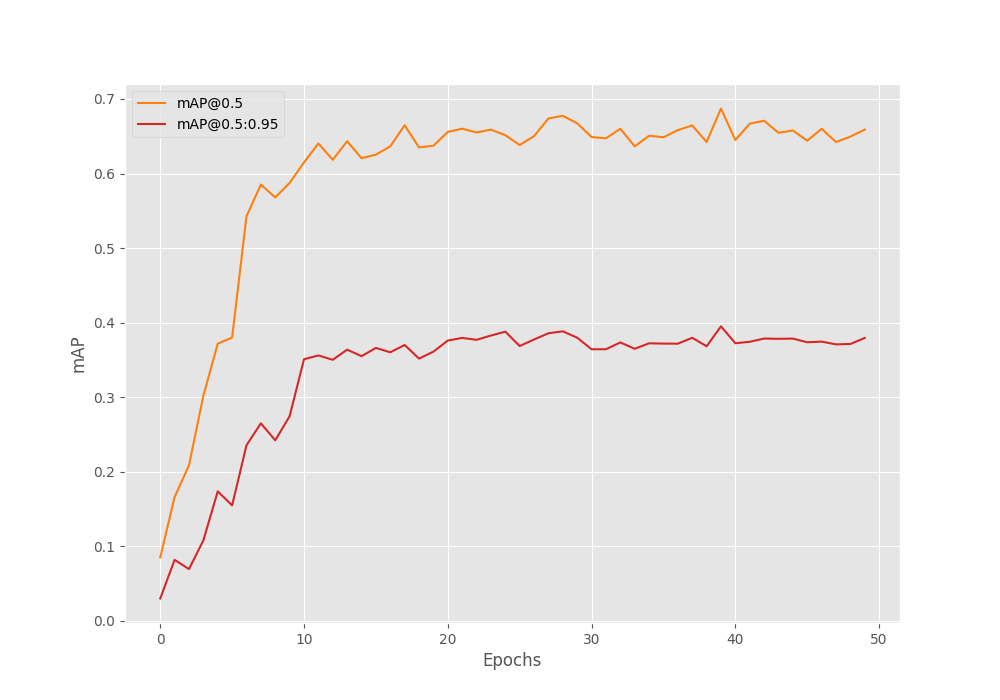

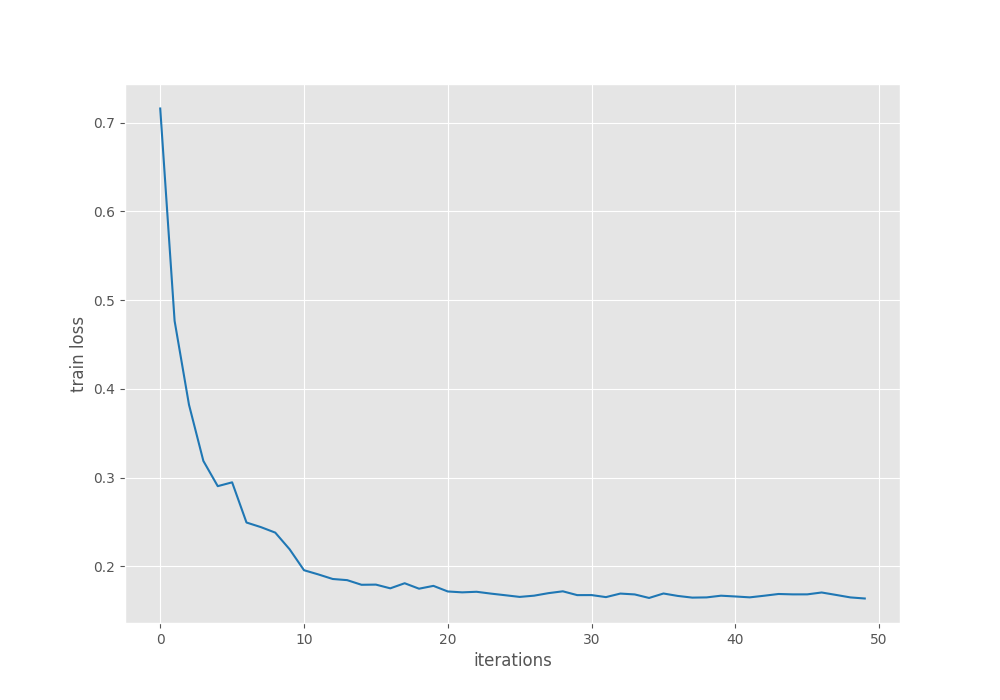

In [23]:
map_img = cv2.imread('/content/Defect-Detection/NetDirectory/outputs/map.png')
loss_img = cv2.imread('/content/Defect-Detection/NetDirectory/outputs/train_loss.png')
cv2_imshow(map_img)
cv2_imshow(loss_img)

# Evaluating the model


In [24]:
#checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)

checkpoint = torch.load('/content/Defect-Detection/NetDirectory/outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

metric = MeanAveragePrecision(class_metrics=True, iou_thresholds=[0.5])
metric_summary = validate(valid_loader, model)

print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")


Validating


  0%|          | 0/22 [00:00<?, ?it/s]

mAP_50: 68.722
mAP_50_95: 68.722


In [34]:
import pandas as pd

def per_class_stat(valid_loader, model):

  stats = validate(valid_loader, model)
  print('\n')
  print(stats)

  print('\n')
  print(f"Classes: {CLASSES}")
  print('\n')
  print('AP / AR per class')
  empty_string = ''
  if len(CLASSES) > 2:
      num_hyphens = 73
      print('-'*num_hyphens)
      print(f"|    | Class{empty_string:<16}| AP{empty_string:<18}| AR{empty_string:<18}|")
      print('-'*num_hyphens)
      class_counter = 0
      for i in range(0, len(CLASSES)-1, 1):
          class_counter += 1
          print(f"|{class_counter:<3} | {CLASSES[i+1]:<20} | {np.array(stats['map_per_class'][i]):.3f}{empty_string:<15}| {np.array(stats['mar_100_per_class'][i]):.3f}{empty_string:<15}|")
      print('-'*num_hyphens)
      print(f"|Avg{empty_string:<23} | {np.array(stats['map']):.3f}{empty_string:<15}| {np.array(stats['mar_100']):.3f}{empty_string:<15}|")
  else:
      num_hyphens = 62
      print('-'*num_hyphens)
      print(f"|Class{empty_string:<10} | AP{empty_string:<18}| AR{empty_string:<18}|")
      print('-'*num_hyphens)
      print(f"|{CLASSES[1]:<15} | {np.array(stats['map']):.3f}{empty_string:<15}| {np.array(stats['mar_100']):.3f}{empty_string:<15}|")
      print('-'*num_hyphens)
      print(f"|Avg{empty_string:<12} | {np.array(stats['map']):.3f}{empty_string:<15}| {np.array(stats['mar_100']):.3f}{empty_string:<15}|")

  return stats

stats = per_class_stat(valid_loader, model)

results_table = pd.DataFrame({
    'Class': ['Bridge', 'COLLAPSE','GAP','SRAF'],
    'AP':[np.round(np.array(stats['map_per_class'][i]),3) for i in range(len(CLASSES)-1)],
    'AR':[np.round(np.array(stats['mar_100_per_class'][i]),3) for i in range(len(CLASSES)-1)]
})

results_table.loc[len(results_table.index)] = ['AVG', np.round(np.array(stats['map']),3 ), np.round(np.array(stats['mar_100']),3 )  ]

print(results_table)
results_table.to_csv('outputs/results.csv')

Validating


  0%|          | 0/22 [00:00<?, ?it/s]



{'map': tensor(0.6872), 'map_50': tensor(0.6872), 'map_75': tensor(-1.), 'map_small': tensor(-1.), 'map_medium': tensor(0.4393), 'map_large': tensor(0.6511), 'mar_1': tensor(0.1671), 'mar_10': tensor(0.7796), 'mar_100': tensor(0.8974), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.7026), 'mar_large': tensor(0.7752), 'map_per_class': tensor([0.9811, 0.3157, 0.5400, 0.9122]), 'mar_100_per_class': tensor([1.0000, 0.7222, 0.9355, 0.9320]), 'classes': tensor([1, 2, 3, 4], dtype=torch.int32)}


Classes: ['__background__', 'bridge', 'collapse', 'gap', 'sraf']


AP / AR per class
-------------------------------------------------------------------------
|    | Class                | AP                  | AR                  |
-------------------------------------------------------------------------
|1   | bridge               | 0.981               | 1.000               |
|2   | collapse             | 0.316               | 0.722               |
|3   | gap                  | 0.540           

In [ ]:

# Read our CSV into a new DataFrame

# Convert the DataFrame into a W&B Table
result_table = wandb.Table(dataframe=results_table)

# Add the table to an Artifact to increase the row
# limit to 200000 and make it easier to reuse
table_artifact = wandb.Artifact("results_artifact", type="results")
table_artifact.add(result_table, "results_table")

# log the raw csv file within an artifact to preserve our data
table_artifact.add_file("outputs/results.csv")

# Start a W&B run to log data

wandb.log({"results": results_table})

# and Log as an Artifact to increase the available row limit!
wandb.log_artifact(table_artifact)

# Finish the run (useful in notebooks)
wandb.finish()

# Model inference on test data


In [ ]:
os.makedirs('inference_outputs/images', exist_ok=True)

COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

DIR_TEST = '/content/Defect-Detection/NetDirectory/custom_data/test'
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")

TRESHOLD_VALUE = 0.5



frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.

for i in range(len(test_images)):
    # Get the image file name for saving output later on.
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()

    print(image.shape)
    # BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # Make the pixel range between 0 and 1.
    #image /= 255.0
    # Bring color channels to front (H, W, C) => (C, H, W).
    image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # Convert to tensor.
    image_input = torch.tensor(image_input, dtype=torch.float).cuda()
    # Add batch dimension.
    image_input = torch.unsqueeze(image_input, 0)
    start_time = time.time()
    # Predictions
    with torch.no_grad():
        outputs = model(image_input.to(DEVICE))
    end_time = time.time()

    # Get the current fps.
    fps = 1 / (end_time - start_time)
    # Total FPS till current frame.
    total_fps += fps
    frame_count += 1

    # Load all detection to CPU for further operations.
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes.
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # Filter out boxes according to `detection_threshold`.
        boxes = boxes[scores >= TRESHOLD_VALUE].astype(np.int32)
        draw_boxes = boxes.copy()
        # Get all the predicited class names.
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # Draw the bounding boxes and write the class name on top of it.
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[CLASSES.index(class_name)]
            # Recale boxes.
            xmin = int((box[0] / image.shape[1]) * orig_image.shape[1])
            ymin = int((box[1] / image.shape[0]) * orig_image.shape[0])
            xmax = int((box[2] / image.shape[1]) * orig_image.shape[1])
            ymax = int((box[3] / image.shape[0]) * orig_image.shape[0])
            cv2.rectangle(orig_image,
                        (xmin, ymin),
                        (xmax, ymax),
                        color[::-1],
                        3)
            cv2.putText(orig_image,
                        class_name,
                        (xmin, ymin-5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.8,
                        color[::-1],
                        2,
                        lineType=cv2.LINE_AA)

        cv2_imshow(orig_image)
        cv2.imwrite(f"inference_outputs/images/{image_name}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')
# Calculate and print the average FPS.
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")


In [ ]:
!zip -r /content/FasterRCNN_inference_images.zip /content/Defect-Detection/NetDirectory/inference_outputs/images

In [37]:
from google.colab import files
files.download('/content/FasterRCNN_inference_images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Tuning hyperparameters for second dataset

In [ ]:
import wandb

sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'train_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'batch_size' : {
            'values' : [6,7, 8, 9, 10]

        'optimizer' : {
            'values' : ['SGD','Adam']
        },
        'learning_rate': {'distribution': 'uniform',
                          'max': 0.01,
                          'min': 0.00001},
        'epochs' : {'value': 5}
    },
    'description' : 'tuning hyperparameters for first dataset'
}


In [ ]:
import pprint

pprint.pprint(sweep_config)
os.makedirs('outputs', exist_ok=True)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'FasterRCNN')

In [ ]:
from custom_utils import (
    Averager,
    SaveBestModel,
    save_model,
    save_loss_plot,
    save_mAP
)
from tqdm.auto import tqdm

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR

import torch
import matplotlib.pyplot as plt
import time
import os




def train(train_data_loader, model, optimizer):
    print('Training')
    model.train()


     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    cumm_loss = 0

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        cumm_loss += loss_value

        losses.backward()
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return cumm_loss/len(train_data_loader)

    #return loss_value

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
train_loss_hist = Averager()

def tune_param(config=None):
  #global train_loss_hist
  wandb.init(project = 'FasterRCNN', config = config)
  config = wandb.config
  train_dataset = create_train_dataset(TRAIN_DIR)
  train_loader = create_train_loader(train_dataset, num_workers = 2, B_SIZE = config.batch_size)

  model = create_model(num_classes = NUM_CLASSES)
  model = model.to(DEVICE)
  params = [p for p in model.parameters() if p.requires_grad]

  # optimizer = torch.optim.SGD(params, lr=config.learning_rate)
  # print(optimizer)

  if config.optimizer == 'SGD':
    optimizer = torch.optim.SGD(params, lr = config.learning_rate, momentum = 0.9)
  elif config.optimizer == 'Adam':
    optimizer = torch.optim.Adam(params, lr = config.learning_rate)
  wandb.watch(model, log= 'all')


  for epoch in range(config.epochs):
      print(f"\nEPOCH {epoch+1} of {config.epochs}")

      # Reset the training loss histories for the current epoch.
      #train_loss_hist.reset()

      # Start timer and carry out training and validation.
      start = time.time()
      train_loss_epoch = train(train_loader, model, optimizer = optimizer)
      print(f"Epoch #{epoch+1} train loss: {train_loss_epoch:.3f}")

      end = time.time()
      print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")


      wandb.log({'epoch': epoch,
                'train_loss': round(train_loss_epoch, 2)
                })

  wandb.finish()


In [ ]:
wandb.agent(sweep_id, function = tune_param, count = 5)

In [ ]:
wandb.finish()

In [ ]:
print('writing a simple message to test pushing from google colab')